In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pydicom
from skimage.transform import resize
import matplotlib.patches as patches

In [3]:
train_label = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
train_label.shape

(30227, 6)

# Formatting Data

In [4]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = (box[0], box[1], box[2], box[3]) if box[0] else (0.0,0.0,0.0,0.0)
    new_box = [int((x)/ r), int((y)/ r), int(w/ r), int(h/ r)] if box[0] else [0.0,0.0,0.0,0.0]

    return new_image, new_box

(1024, 1024)


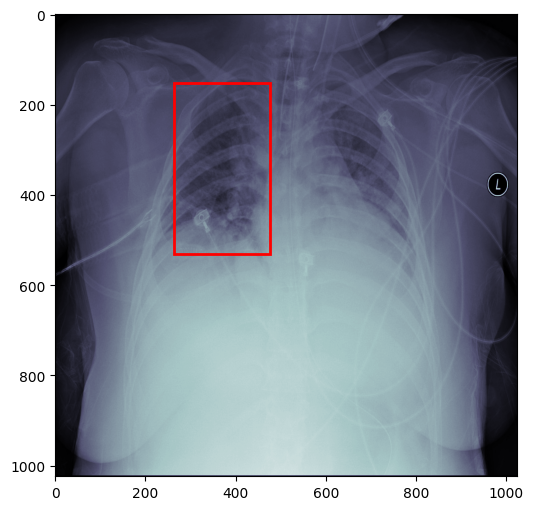

In [5]:
dcm_path = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'

image_array = pydicom.dcmread(dcm_path).pixel_array
# image_array = cv.resize(image_array, (224, 224))

print(image_array.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))  
ax.imshow(image_array, cmap='bone')          


rect = patches.Rectangle((264.0, 152.0), 213.0, 379.0, 
                         edgecolor='r', facecolor='none', linewidth=2)
ax.add_patch(rect)                         

plt.show()    

[62, 36, 50, 90]


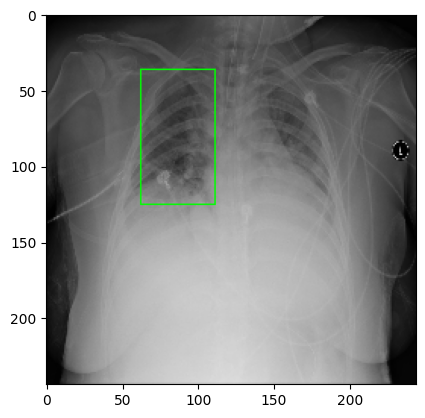

In [6]:

datapath = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
temp_img = pydicom.dcmread(datapath).pixel_array
temp_box = [264.0, 152.0, 213.0, 379.0]

temp_img_formated, box = format_image(temp_img, temp_box)
print(box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 1)

plt.imshow(temp_color_img)
# plt.axis("off")
plt.show()

In [7]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

# uncomment the following line if you want to force CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

2.17.0


In [8]:
train_labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [9]:
from tqdm import tqdm 
import os
import pydicom
import numpy as np
import tensorflow as tf
import math

def data_load(dataset, batch_size=3, full_data_path="/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/", image_ext=".dcm",ds_type='not_trian'):
    X = []
    Y = []

    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Loading data"):
        filename = row['patientId'] 
        temp_img = pydicom.dcmread(os.path.join(full_data_path, filename + image_ext)).pixel_array
        temp_box = [row['x'], row['y'], row['width'], row['height']] if not math.isnan(row['x']) else [0.0, 0.0, 0.0, 0.0]
        img, box = format_image(temp_img, temp_box)

        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, row['Target'])

        X.append(img)
        Y.append(label)
    # print(len(X))
    # print(len(Y))
    
    
    X = np.array(X)
    data_X_len = len(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result,data_X_len
raw_train_ds,train_len = data_load(train_labels[:6001],ds_type="train")
print(train_len)
raw_valid_ds,valid_len = data_load(train_labels[6001:6301],ds_type="not train")
raw_test_ds, test_len = data_load(train_labels[6301:6501],ds_type="not train")

Loading data: 100%|██████████| 6001/6001 [00:51<00:00, 116.59it/s]


6001


Loading data: 100%|██████████| 200/200 [00:01<00:00, 114.03it/s]


In [11]:
import os
cpu_count = os.cpu_count()
print(f"Available CPU cores: {cpu_count}")


Available CPU cores: 4


In [12]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [13]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [14]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(dataset) // 4)
    dataset = dataset.repeat()
    return dataset

In [15]:
train_ds = tune_training_ds(raw_train_ds)
validation_ds = tune_validation_ds(raw_valid_ds)


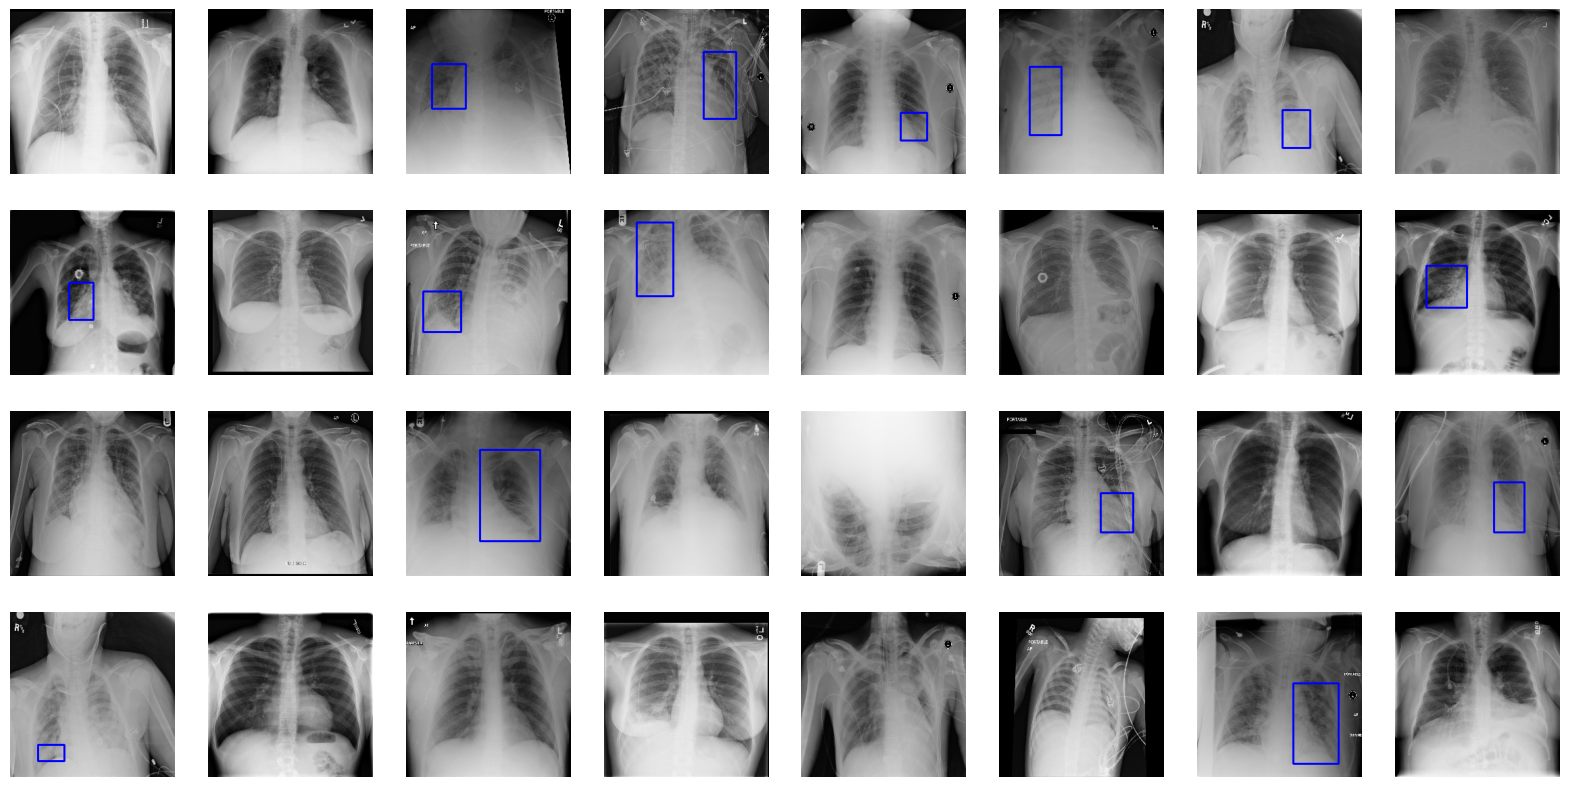

In [16]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        # print(labels.shape)
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

In [17]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4, name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [18]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 244, 244, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 242, 242, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 121, 121, 16)   │              0 │ conv2d[0][0]           │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 119, 119, 32)   │          4,640 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 59, 59, 32)     │              0 │ conv2d_1[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 57, 57, 64)     │         18,496 │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 57, 57, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 28, 28, 64)     │              0 │ dropout[0][0]          │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50176)          │              0 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │      3,211,328 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_head (Dense)   │ (None, 2)              │            130 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor_head (Dense)    │ (None, 4)              │            260 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

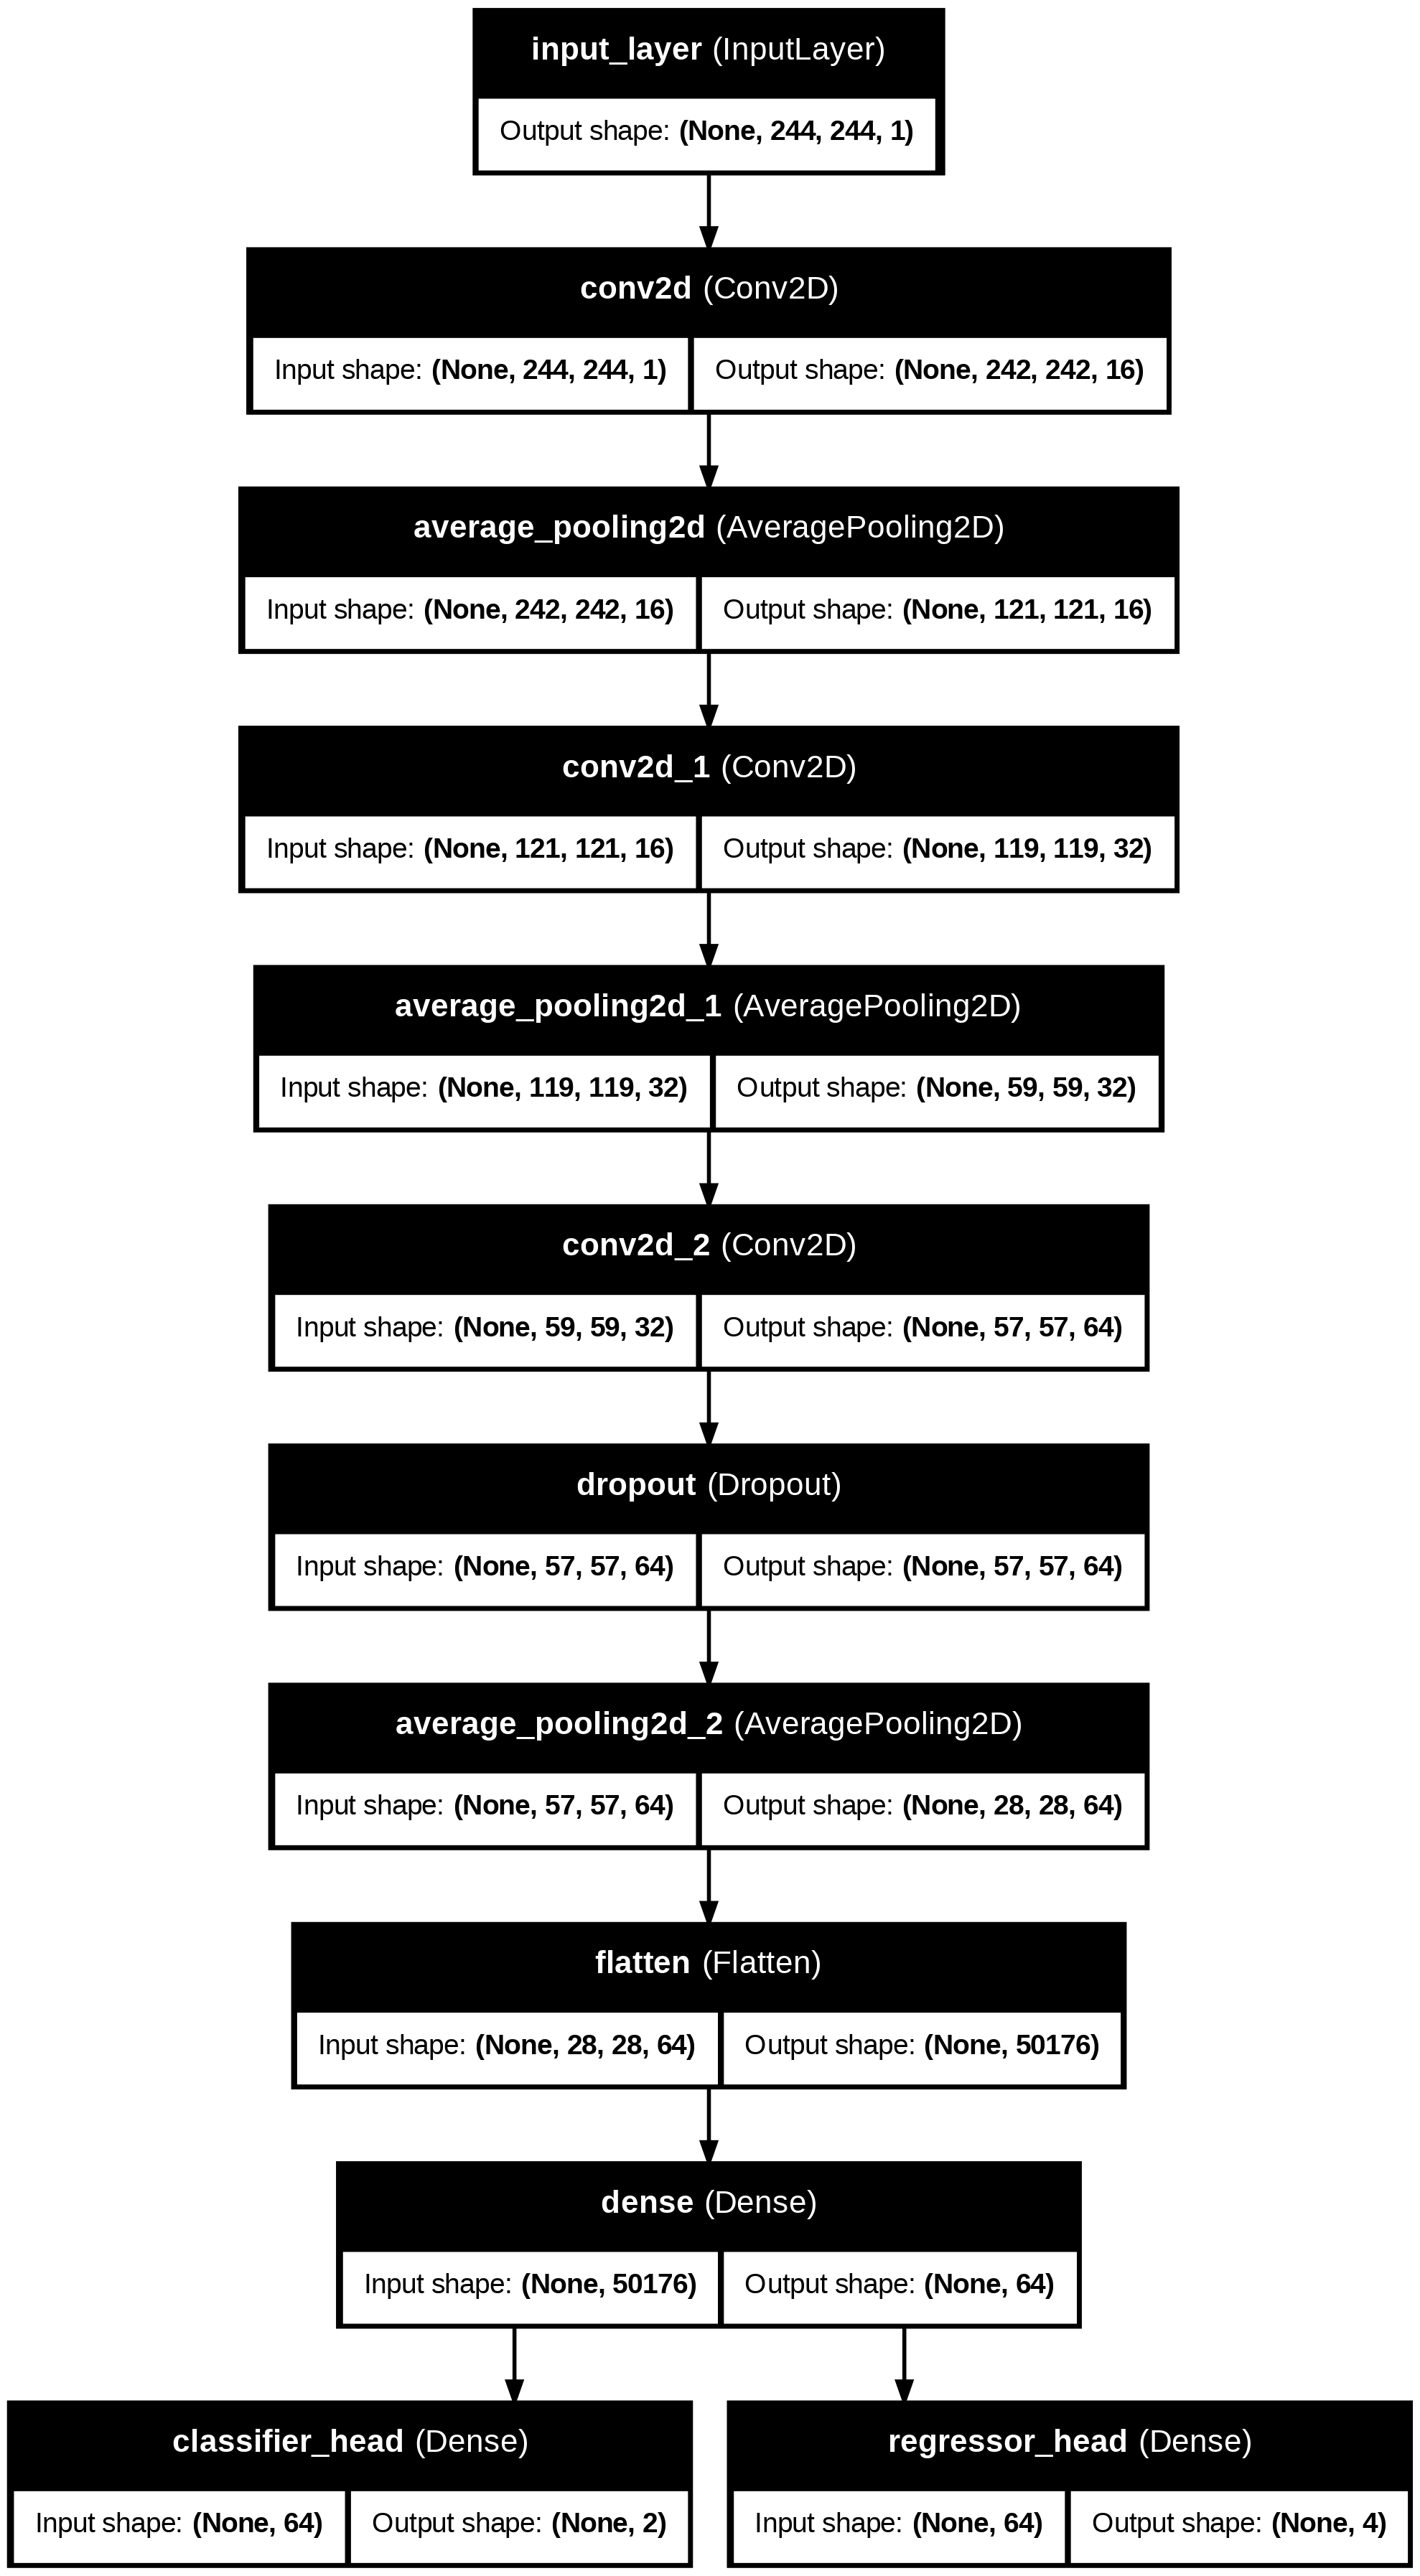

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [20]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=(6000 // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS)

Epoch 1/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - classifier_head_accuracy: 0.6786 - loss: 0.7605 - regressor_head_mse: 0.1716 - val_classifier_head_accuracy: 0.8133 - val_loss: 0.4112 - val_regressor_head_mse: 0.0199
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - classifier_head_accuracy: 0.7573 - loss: 0.5469 - regressor_head_mse: 0.0342 - val_classifier_head_accuracy: 0.8533 - val_loss: 0.3589 - val_regressor_head_mse: 0.0146
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - classifier_head_accuracy: 0.7622 - loss: 0.5300 - regressor_head_mse: 0.0308 - val_classifier_head_accuracy: 0.9067 - val_loss: 0.3887 - val_regressor_head_mse: 0.0135
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - classifier_head_accuracy: 0.7872 - loss: 0.5025 - regressor_head_mse: 0.0296 - val_classifier_head_accuracy: 0.9200 - val_loss: 0.2776 - val_regressor_head_mse: 0.0123
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - classifier_head_accuracy: 0.7817 - loss: 0.4961

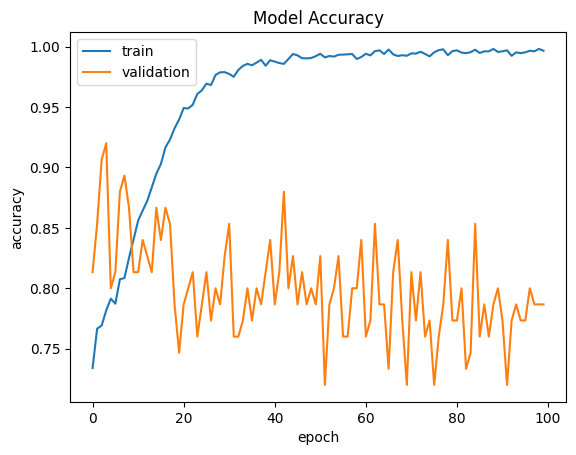

In [21]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluation

In [22]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = boxA[2] * boxA[3]  
    boxBArea = boxB[2] * boxB[3]  

    if boxAArea == 0 or boxBArea == 0:
        return 0.0  

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [23]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

20


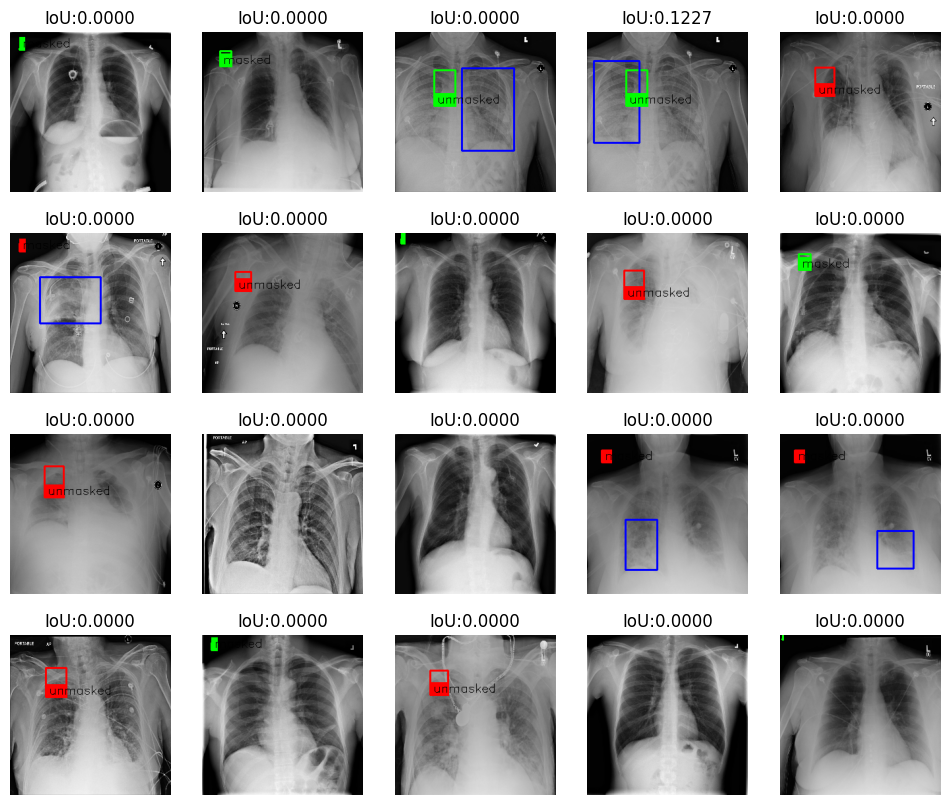

In [24]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")


In [25]:
output_dir = "output_predictions"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(200).as_numpy_iterator())
print(f"Test Data Size: {len(test_list)}")

correct_count = 0
total_count = 0
iou_list = []

for i in range(len(test_list)):

    # ax = plt.subplot(4, 5, i + 1)

    image, labels = test_list[i]
    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]

    image = image[0]
    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)  
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)  
        correct_count += 1

    total_count += 1

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), 
                 (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), 
               cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())
    iou_list.append(IoU)

    output_path = os.path.join(output_dir, f"prediction_{i + 1}.png")
    cv.imwrite(output_path, cv.cvtColor(image_color, cv.COLOR_RGB2BGR))  

accuracy = correct_count / total_count
average_iou = np.mean(iou_list)

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean IoU: {average_iou:.4f}")

plt.savefig(os.path.join(output_dir, "all_predictions.png"))
plt.show()


Test Data Size: 200
準確率 (Accuracy): 0.7250
平均 IoU (Mean IoU): 0.0148


<Figure size 1200x1000 with 0 Axes>

In [26]:
import shutil

shutil.make_archive('predictions', 'zip', output_dir)


'/kaggle/working/predictions.zip'